In [1]:
import dgl
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

/home/antonio/dev/pyvenvs/graph_classification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
make_pth = lambda pth: os.sep.join(['..', 'datasets', pth])

In [3]:
dspth = make_pth('reflacx_densnet225_scanpath')
dspth

'../datasets/reflacx_densnet225_scanpath'

In [4]:
def get_node(graph, i):
    assert 0 <= i < len(graph.nodes())
    result = {}
    for k in graph.ndata.keys():
        result[k] = graph.ndata[k][i]
    return result

def get_edge(adjmat, i, j):
    assert 0 <= i < adjmat.shape[0]
    assert 0 <= j < adjmat.shape[1]
    return adjmat[i, j]

In [5]:
ds = dgl.data.CSVDataset(dspth)

Done loading data from cached files.


In [6]:
g, labels = ds[0]
if torch.cuda.device_count() > 0:
    g = g.to(torch.device('cuda:0'))

#### Calculating observed area from image

In [7]:
def mark_area(node, canvas):
    min_x, min_y = [int(a) for a in node['norm_top_left'] * canvas.shape[1]]
    max_x, max_y = [int(a) for a in node['norm_bottom_right'] * canvas.shape[0]]
    canvas[min_x:max_x, min_y:max_y] = 1

In [8]:
def observed_area_percent(graph, resolution=1000):
    canvas = np.zeros((resolution, resolution))
    for i in range(len(graph.nodes())):
        mark_area(get_node(graph, i), canvas)

    return np.sum(canvas) / (resolution ** 2), canvas

In [9]:
def dataset_area_percent(dataset, resolution=1000):
    result = {}
    sample_canvas = None
    for i, (g, _) in enumerate(dataset):
        result[i], sample_canvas = observed_area_percent(g, resolution)
    return result, sample_canvas

In [10]:
areas, img = dataset_area_percent(ds)

KeyboardInterrupt: 

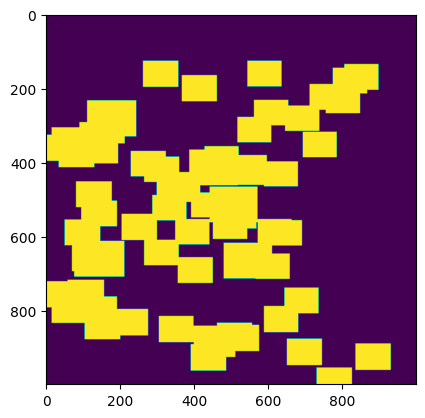

In [ ]:
plt.imshow(img)

In [ ]:
vs = areas.values()
min(vs), max(vs), sum(vs)/len(vs)

(0.0, 0.744473, 0.4123161822353329)

(array([ 20.,   0.,   3.,  20.,  93., 144., 159., 172., 170., 245., 341.,
        375., 352., 349., 269., 177.,  91.,  45.,  19.,   7.]),
 array([0.        , 0.03722365, 0.0744473 , 0.11167095, 0.1488946 ,
        0.18611825, 0.2233419 , 0.26056555, 0.2977892 , 0.33501285,
        0.3722365 , 0.40946015, 0.4466838 , 0.48390745, 0.5211311 ,
        0.55835475, 0.5955784 , 0.63280205, 0.6700257 , 0.70724935,
        0.744473  ]),
 <BarContainer object of 20 artists>)

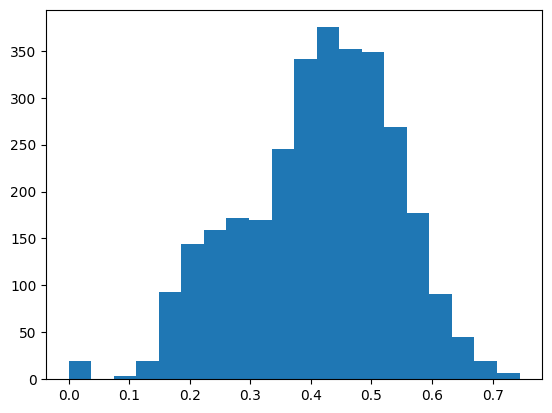

In [ ]:
plt.hist(vs, bins=20)

### Testing grids

In [ ]:
def gridify(g, dim, aggr_by_duration=True):
    result = np.zeros((dim, dim, 3))
    for node in (get_node(g, i) for i in range(len(g.nodes()))):
        x = node['norm_x']
        y = node['norm_y']
        x = min(dim - 1, int(x * dim))
        y = min(dim - 1, int(y * dim))

        incr = node['duration'] if aggr_by_duration else 1
        result[x, y] += (incr, incr, incr)

    
    return result

def display_grid(grid, zero_color=(255, 0, 255)):
    grid[np.where(grid == (0, 0, 0))[:2]] = zero_color
    return grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


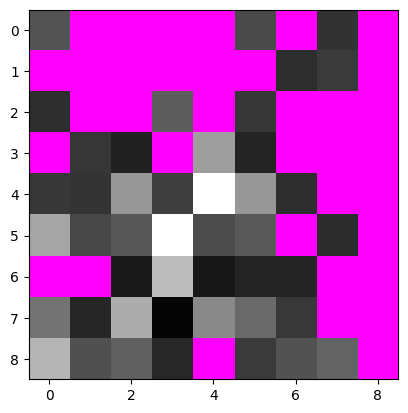

In [ ]:
plt.imshow(display_grid(gridify(ds[10][0], 9)))

In [ ]:
def grid_stats(dataset, dims, aggr_by_duration=True):
    result = {x: {'zero_counts': [],
                  'grids': []}
              for x in dims}
    
    for i, (g, _) in enumerate(dataset):
        for dim in dims:
            grid = gridify(g, dim, aggr_by_duration=aggr_by_duration)
            result[dim]['zero_counts'].append(len(np.where(grid == (0, 0, 0))[0]))
            result[dim]['grids'].append(grid)

    for dim in dims:
        result[dim]['avg_zeros'] = sum(result[dim]['zero_counts']) / len(result[dim]['zero_counts'])
    return result


In [ ]:
x = grid_stats(ds, [2, 3, 4, 5, 8, 10])

In [ ]:
{d: x[d]['avg_zeros'] for d in x}

{2: 0.08161258603736479,
 3: 1.3067846607669618,
 4: 7.094395280235989,
 5: 18.250737463126843,
 8: 90.07177974434612,
 10: 172.45624385447394}

### Analisys of diagnostics distribution

In [11]:
labels = None
for _, label in ds:
    label = label.unsqueeze(0)
    if labels is None:
        labels = label
    else:
        labels = torch.cat([labels, label])

In [12]:
labels.count_nonzero(dim=0) / labels.shape[0]

tensor([0.2770, 0.2681, 0.2347, 0.1282, 0.0347, 0.1403])

In [13]:
hists = torch.cat([(torch.histc(labels[:, i], 6) / labels.shape[0]).unsqueeze(0)
                   for i in range(labels.shape[1])],
                  dim=0)

In [14]:
hists = hists.detach().numpy()
hists

array([[7.23041654e-01, 3.27761401e-04, 2.29432969e-03, 1.80268772e-02,
        1.05539165e-01, 1.50770232e-01],
       [7.31891155e-01, 3.27761401e-04, 3.93313682e-03, 1.70435924e-02,
        7.80072138e-02, 1.68797120e-01],
       [7.65322864e-01, 3.27761401e-04, 4.91642067e-03, 1.99934449e-02,
        3.47427055e-02, 1.74696818e-01],
       [8.71845305e-01, 0.00000000e+00, 3.27761401e-04, 9.83284134e-03,
        3.70370373e-02, 8.09570625e-02],
       [9.65257287e-01, 1.31104561e-03, 1.31104561e-03, 3.93313682e-03,
        4.91642067e-03, 2.32710578e-02],
       [8.59718144e-01, 3.27761401e-04, 2.94985250e-03, 1.76991150e-02,
        5.63749596e-02, 6.29301891e-02]], dtype=float32)

In [15]:
np.arange(0, 1, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [16]:
hists[0]

array([7.23041654e-01, 3.27761401e-04, 2.29432969e-03, 1.80268772e-02,
       1.05539165e-01, 1.50770232e-01], dtype=float32)

In [17]:
PHASE_1_LABELS = ["Airway wall thickening",
                  "Atelectasis",
                  "Consolidation",
                  "Emphysema",
                  "Enlarged cardiac silhouette",
                  "Fibrosis",
                  "Fracture",
                  "Groundglass opacity",
                  "Mass",
                  "Nodule",
                  "Pleural effusion",
                  "Pleural thickening",
                  "Pneumothorax",
                  "Pulmonary edema",
                  "Wide mediastinum"]

PHASE_2_3_LABELS = ["Abnormal mediastinal contour",
                    "Acute fracture",
                    "Atelectasis",
                    "Consolidation",
                    "Enlarged cardiac silhouette",
                    "Enlarged hilum",
                    "Groundglass opacity",
                    "Hiatal hernia",
                    "High lung volume / emphysema, Interstitial lung disease",
                    "Lung nodule or mass",
                    "Pleural abnormality",
                    "Pneumothorax",
                    "Pulmonary edema"]

labels = [k for k in PHASE_1_LABELS if k in PHASE_2_3_LABELS]

In [18]:
torch.tile(torch.arange(0.2, 1.05, 1/6).unsqueeze(1), (1, 3))

tensor([[0.2000, 0.2000, 0.2000],
        [0.3667, 0.3667, 0.3667],
        [0.5333, 0.5333, 0.5333],
        [0.7000, 0.7000, 0.7000],
        [0.8667, 0.8667, 0.8667],
        [1.0333, 1.0333, 1.0333]])

In [20]:
from matplotlib import colormaps

In [25]:
cmap = colormaps.get_cmap('Accent')

In [24]:
cmap.colors

((0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (1.0, 1.0, 0.6),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 (0.4, 0.4, 0.4))

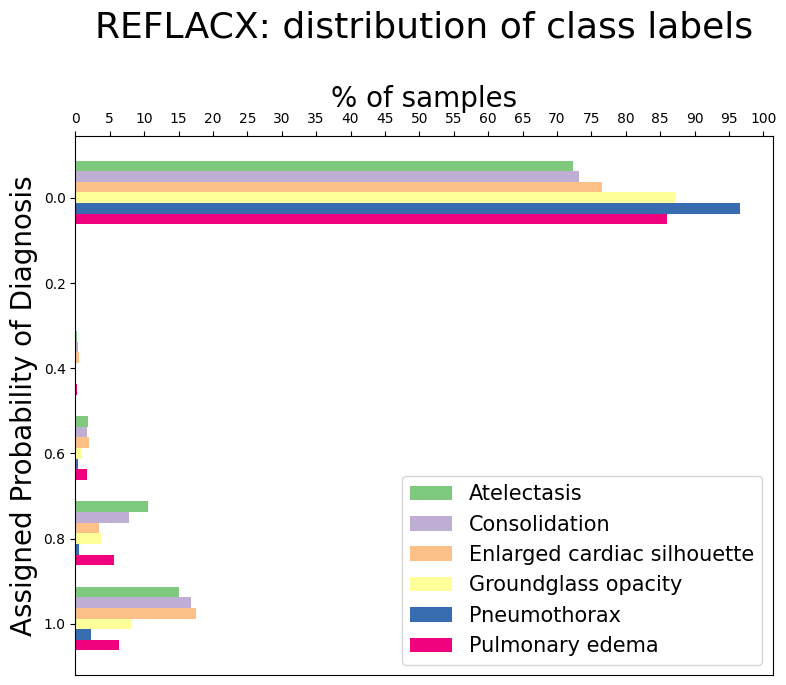

In [36]:
colors = [[0.2000, 0.2000, 0.2000],
        [0.3667, 0.3667, 0.3667],
        [0.5333, 0.5333, 0.5333],
        [0.7000, 0.7000, 0.7000],
        [0.8667, 0.8667, 0.8667],
        [0.95, 0.95, 0.95]]
patterns = [ "/" , "\\" , "-" , "+" , "x", ".", "O", ".", "*" ]

xs = np.arange(0, 1.2, 0.2)
plt.figure(figsize=(9, 7))
fontsize = 20

for i in range(hists.shape[0]):
    width = 0.15 / hists.shape[1]
    y = hists[i] * 100
    plt.barh((xs - width * hists.shape[1] / 2) + width * i,
            y,
            width,
            label=labels[i],
            color = cmap.colors[i])
plt.title("REFLACX: distribution of class labels\n", fontsize=fontsize + 6)
plt.gca().xaxis.tick_top()
plt.xlabel('% of samples', fontsize=fontsize)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Assigned Probability of Diagnosis', fontsize=fontsize)
plt.xticks(np.arange(0, 101, 5.0))
plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})
plt.show()
